In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 

sns.set_style("darkgrid")

In [2]:
df = pd.read_csv("/kaggle/input/insurance/insurance.csv")
df.sample(5)

,age,sex,bmi,children,smoker,region,charges
218,26,female,29.92,1,no,southeast,3392.9768
1062,59,male,41.14,1,yes,southeast,48970.2476
135,22,female,28.05,0,no,southeast,2155.6815
1200,37,male,24.32,2,no,northwest,6198.7518
14,27,male,42.13,0,yes,southeast,39611.7577


To predict charges, we have a regression problem 

Features are:
<li>Age: The age of the insured</li>
<li>sex: Gender</li>
<li>children: Number of children</li>
<li>smoker: whether the insured is a smoker or not</li>
<li>region: the region where the insured is living, particularly in the US</li>

Some suspicions are:
<li>The older -> higher charges</li> 
<li>The sex -> not really sure</li> 
<li>Children -> the more children one has, the higher the charges (more likely to get into accidents)</li>
<li>region -> maybe some areas might be more dangerous, resulting in higher charges</li>



In [13]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             1338 non-null   int64   
 1   sex             1338 non-null   object  
 2   bmi             1338 non-null   float64 
 3   children        1338 non-null   int64   
 4   smoker          1338 non-null   object  
 5   region          1338 non-null   object  
 6   charges         1338 non-null   float64 
 7   Age_Categories  1338 non-null   category
 8   BMI_categories  1338 non-null   category
dtypes: category(2), float64(2), int64(2), object(3)
memory usage: 76.3+ KB


## Data Cleaning 

In [3]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Looks like there area no missing data 

We can put our age into bins 

Particularly, Age and BMI

In [5]:
df["Age_Categories"] = pd.cut(df["age"], bins = [0,20,40, 60, np.inf], labels = ["Teenagers", "Adults", "Old Adults", "Elderly"])
df.head()

,age,sex,bmi,children,smoker,region,charges,Age_Categories
0,19,female,27.900,0,yes,southwest,16884.92400,Teenagers
1,18,male,33.770,1,no,southeast,1725.55230,Teenagers
2,28,male,33.000,3,no,southeast,4449.46200,Adults
3,33,male,22.705,0,no,northwest,21984.47061,Adults
4,32,male,28.880,0,no,northwest,3866.85520,Adults


In [8]:
df["BMI_categories"] = pd.cut(df["bmi"], bins = [0, 18.5, 24.9, 29.9, 34.9, np.inf], labels = ["Underweight", "Normal", "Overweight", "Obese", "Extremely_Obese"])
df.head()

,age,sex,bmi,children,smoker,region,charges,Age_Categories,BMI_categories
0,19,female,27.900,0,yes,southwest,16884.92400,Teenagers,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,Teenagers,Obese
2,28,male,33.000,3,no,southeast,4449.46200,Adults,Obese
3,33,male,22.705,0,no,northwest,21984.47061,Adults,Normal
4,32,male,28.880,0,no,northwest,3866.85520,Adults,Overweight


## I'm not judging by any chance, took this off the health index 

# Data Visualization 

Age 

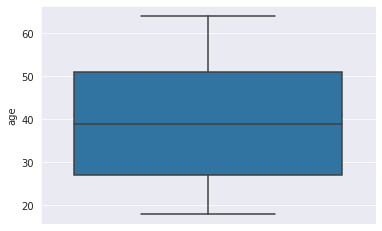

In [10]:
sns.boxplot(y = "age", data = df )
plt.show()

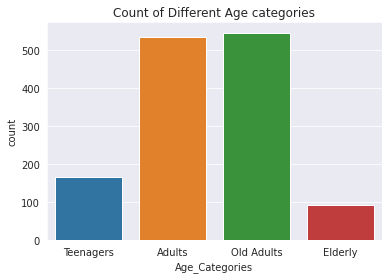

In [12]:
sns.countplot(x = "Age_Categories", data = df)
plt.title("Count of Different Age categories")
plt.show()

It looks like most of the dataset consists of mostly adults and old adults 

BMI

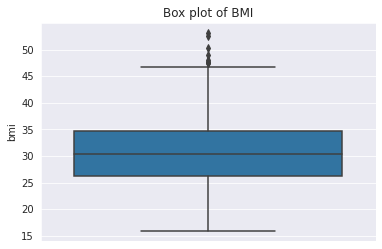

In [17]:
sns.boxplot(y = "bmi", data = df)
plt.title("Box plot of BMI")
plt.show()

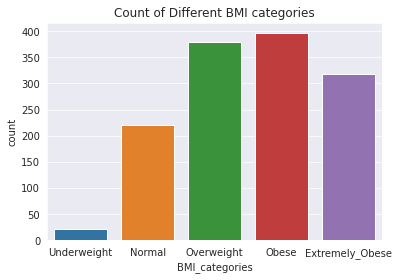

In [18]:
sns.countplot(x = "BMI_categories", data = df)
plt.title("Count of Different BMI categories")
plt.show()

Looks like a lot of people in this dataset are overweight or extremely overweight, as seen from the box plot, there are a couple whose BMI is extremely high 

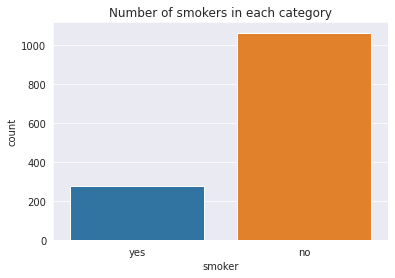

In [20]:
sns.countplot(x = "smoker", data = df)
plt.title("Number of smokers in each category")
plt.show()


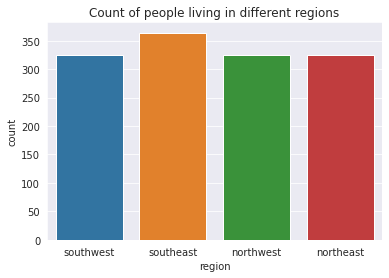

In [21]:
sns.countplot(x = "region", data = df)
plt.title("Count of people living in different regions")
plt.show()

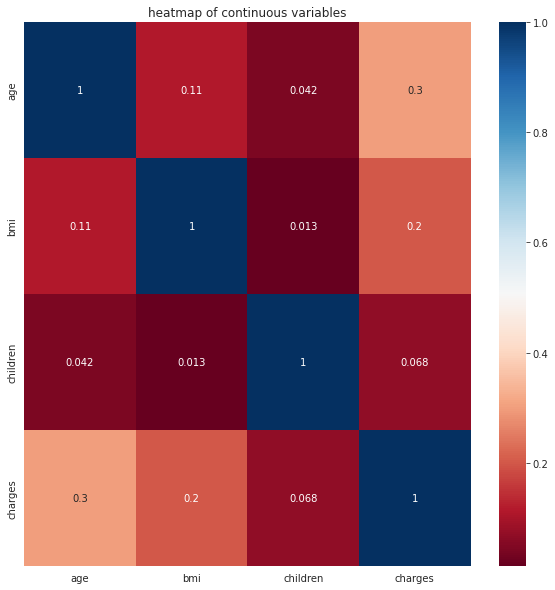

In [24]:
plt.figure(figsize = (10,10))
plt.title("heatmap of continuous variables")
sns.heatmap(df.corr(), cmap = "RdBu", annot = True)
plt.show()

Looks like there are no features which have extremely high collinearity

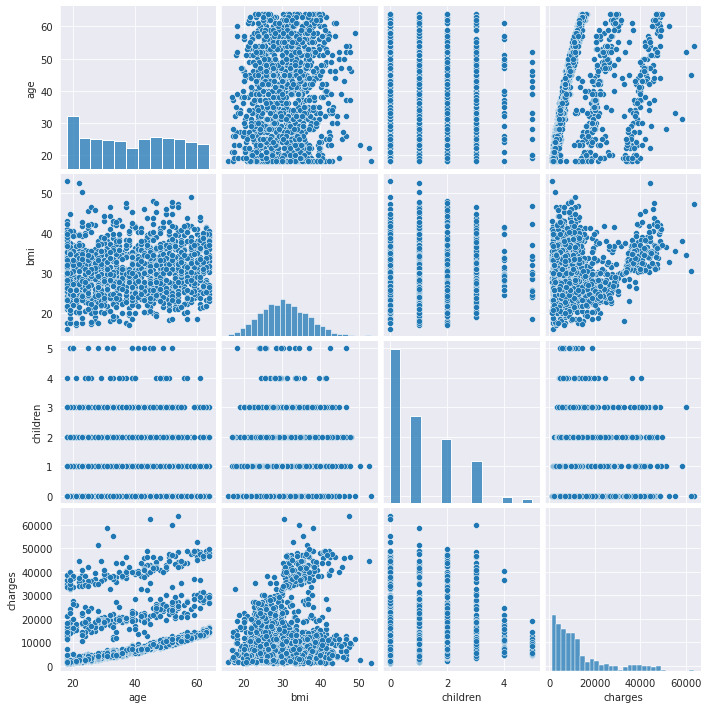

In [26]:
sns.pairplot(df)
plt.show()

## Building the data pipeline 

I decided to use continuous variables instead of categorical attributes for AGE group and BMI because there seems to be not much outliers / noise in the dataset as seen in the boxplots above

In [33]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split 

In [28]:
df.head()

,age,sex,bmi,children,smoker,region,charges,Age_Categories,BMI_categories
0,19,female,27.900,0,yes,southwest,16884.92400,Teenagers,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,Teenagers,Obese
2,28,male,33.000,3,no,southeast,4449.46200,Adults,Obese
3,33,male,22.705,0,no,northwest,21984.47061,Adults,Normal
4,32,male,28.880,0,no,northwest,3866.85520,Adults,Overweight


In [29]:
x = df[["age", "sex", "bmi", "children", "smoker", "region"]]
y = df["charges"]

In [42]:
x

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


In [34]:
num_pipeline = Pipeline([
    ("Min-Max scaler", MinMaxScaler())
])

cat_pipeline = Pipeline([
    ("One-Hot", OneHotEncoder())
])


In [52]:
full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, ["age", "bmi", "children"]),
    ("categorical", cat_pipeline, ["sex", "smoker", "region" ])
])

In [53]:
print(x.columns)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')


In [54]:
x_prepared = full_pipeline.fit_transform(x)

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x_prepared, y, test_size = 0.2, random_state = 0)

In [61]:
# simple linear regression 

from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred = lin_reg.predict(x_test)

print("Linear Regression's MSE: ", mean_squared_error(y_test, y_pred))
print("Linear Regression's R squared value: ", r2_score(y_test, y_pred))

Linear Regression's MSE:  31865016.086419683
Linear Regression's R squared value:  0.7997547688604641


In [64]:
# lasso 
from sklearn.linear_model import Lasso 

Las = Lasso()
Las.fit(x_train, y_train)
y_pred = Las.predict(x_test )
print("Lasso's MSE: ", mean_squared_error(y_test, y_pred))
print("Lasso's R squared value: ", r2_score(y_test, y_pred))

Lasso's MSE:  31838305.42103545
Lasso's R squared value:  0.7999226232669785


Looks like Lasso regression definitely has a miniscule improvement from linear regression

In [63]:
# random forest regressor 

from sklearn.ensemble import RandomForestRegressor

rgr = RandomForestRegressor(max_depth = 5)
rgr.fit(x_train, y_train)
y_pred = rgr.predict(x_test)
print("Random Forest Regressor 's MSE: ", mean_squared_error(y_test, y_pred))
print("Linear Regression's R squared value: ", r2_score(y_test, y_pred))

Linear Regression's MSE:  16276828.44681349
Linear Regression's R squared value:  0.8977136159068244


Its probably going to be an overkill for deep learning, but lets try doing it!

## ANN 

In [82]:
import tensorflow as tf 
from tensorflow.keras import Model 
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import tensorflow_addons as tfa


In [72]:
x_train.shape

(1070, 11)

In [101]:
model = Sequential([
    Dense(units = 30, kernel_initializer = "he_normal", activation = "relu", input_dim = x_train.shape[1]),
    # dropout layer 
    Dropout(0.2),
    Dense(units = 20, kernel_initializer = "he_normal", activation = "relu"),
    Dropout(0.2),
    Dense(units = 20, kernel_initializer = "he_normal", activation = "relu"),
    Dense(units = 10, kernel_initializer = "he_normal", activation = "relu"),
    Dense(1, kernel_initializer = "he_normal", activation = "linear")
    
])
msle = MeanSquaredLogarithmicError()
model.compile(
    loss = "mean_squared_error",
    optimizer = "adam",
    metrics = tf.keras.metrics.MeanSquaredError()
)
history = model.fit(x_train, y_train, epochs = 100, batch_size = 64, validation_split = 0.2)

Epoch 1/100
14/14 [==============================] - 1s 17ms/step - loss: 304030912.0000 - mean_squared_error: 304030912.0000 - val_loss: 372029088.0000 - val_mean_squared_error: 372029088.0000
Epoch 2/100
14/14 [==============================] - 0s 5ms/step - loss: 304015680.0000 - mean_squared_error: 304015680.0000 - val_loss: 372011360.0000 - val_mean_squared_error: 372011360.0000
Epoch 3/100
14/14 [==============================] - 0s 5ms/step - loss: 303994272.0000 - mean_squared_error: 303994272.0000 - val_loss: 371978400.0000 - val_mean_squared_error: 371978400.0000
Epoch 4/100
14/14 [==============================] - 0s 5ms/step - loss: 303956000.0000 - mean_squared_error: 303956000.0000 - val_loss: 371913504.0000 - val_mean_squared_error: 371913504.0000
Epoch 5/100
14/14 [==============================] - 0s 5ms/step - loss: 303880256.0000 - mean_squared_error: 303880256.0000 - val_loss: 371791776.0000 - val_mean_squared_error: 371791776.0000
Epoch 6/100
14/14 [===============

In [102]:
type(history)

keras.callbacks.History

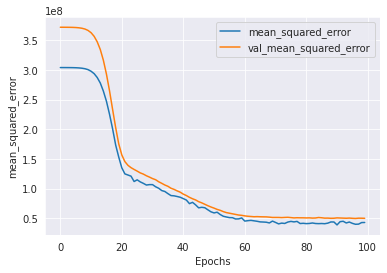

In [103]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_error')

In [105]:
y_pred = model.predict(x_test)

print("ANN's MSE: ", mean_squared_error(y_test, y_pred))
print("ANN's R squared value: ", r2_score(y_test, y_pred))

ANN's MSE:  32703747.246979643
ANN's R squared value:  0.7944840382681818
